In [ ]:
import gdown
import matplotlib.pyplot as plt
import networkx as nx
import numpy as np
import pprint
import random
import pandas as pd
import pulp
import itertools
import requests
import random
from geopy.distance import geodesic
import time
import pandas as pd
import os

Downloading...
From (original): https://drive.google.com/uc?id=1zq17RENYLU1qrE2gNPsxRAPoysWMZAqf
From (redirected): https://drive.google.com/uc?id=1zq17RENYLU1qrE2gNPsxRAPoysWMZAqf&confirm=t&uuid=d556ab7d-ec2f-4b74-8dba-4900ef5e508e
To: /content/mpsis_setup.py
100%|██████████| 12.1k/12.1k [00:00<00:00, 8.68MB/s]


Mounted at /content/drive


In [ ]:
def generate_random_point(sw_lat, sw_lng, ne_lat, ne_lng):
    lat = random.uniform(sw_lat, ne_lat)
    lng = random.uniform(sw_lng, ne_lng)
    return lat, lng

def snap_to_road(lat, lng, api_key):
    url = f'https://roads.googleapis.com/v1/nearestRoads?points={lat},{lng}&key={api_key}'
    response = requests.get(url)
    data = response.json()
    if 'snappedPoints' in data and len(data['snappedPoints']) > 0:
        snapped_point = data['snappedPoints'][0]['location']
        return snapped_point['latitude'], snapped_point['longitude']
    return None

def get_road_distance_time(origin, destination, api_key):
    origin_str = f'{origin[0]}, {origin[1]}'
    destination_str = f'{destination[0]}, {destination[1]}'
    departure_time = int(time.time()) + 24 * 3600
    url = (
        f'https://maps.googleapis.com/maps/api/distancematrix/json?units=metric&origins={origin_str}'
        f'&destinations={destination_str}&mode=driving&departure_time={departure_time}&key={api_key}'
    )
    response = requests.get(url)
    data = response.json()

    if data['status'] == 'OK':
        element = data['rows'][0]['elements'][0]
        if element['status'] == 'OK':
            distance_text = element['distance']['text']
            distance = float(distance_text.replace(' km', '').replace(',', ''))

            duration_text = element['duration']['text']
            duration_parts = duration_text.split()
            duration = int(duration_parts[0])
            if "hour" in duration_text:
                duration = int(duration_parts[0]) * 60 + int(duration_parts[2])

            return distance, duration
        else:
            return None, None
    else:
        return None, None

def find_center(sw_lat, sw_lng, ne_lat, ne_lng):
    center_lat = (sw_lat + ne_lat) / 2
    center_lng = (sw_lng + ne_lng) / 2
    return center_lat, center_lng

def generate_list(n, target_sum):
    if n <= 1:
        raise ValueError("The length of the list must be greater than 1.")
    if target_sum < 0:
        raise ValueError("The target sum must be non-negative.")
    result = [0]
    random_values = np.random.rand(n - 1)
    random_values *= target_sum / np.sum(random_values)
    rounded_values = np.round(random_values, 2)
    difference = target_sum - np.sum(rounded_values)

    if len(rounded_values) > 0:
        rounded_values[-1] += difference

    result.extend(rounded_values)

    return result

def crop_matrix(data, N):
    return [row[:N] for row in data[:N]]

import numpy as np

def generate_demand_list(n, m, target_sum):
    if n <= 1:
        raise ValueError("The length of the list must be greater than 1.")
    if m >= n:
        raise ValueError("M must be less than N.")
    if target_sum < 0:
        raise ValueError("The target sum must be non-negative.")

    random_values = np.random.rand(n - m - 1)
    random_values *= target_sum / np.sum(random_values)
    rounded_values = np.round(random_values, 2)
    difference = target_sum - np.sum(rounded_values)

    if len(rounded_values) > 0:
        rounded_values[-1] += difference

    zeros_list = [0] * m

    result = list(rounded_values) + zeros_list

    random.shuffle(result)

    result = [-1] + result

    return result
def replace_zeros_with_sum(input_list, target_sum):
    zero_positions = [i for i, value in enumerate(input_list) if value == 0]
    num_zeros = len(zero_positions)

    result = input_list.copy()

    if num_zeros == 0:
        raise ValueError("There are no zeros to replace in the list.")

    random_values = np.random.rand(num_zeros)
    random_values *= target_sum / np.sum(random_values)
    rounded_values = np.round(random_values, 2)
    difference = target_sum - np.sum(rounded_values)

    if len(rounded_values) > 0:
        rounded_values[-1] += difference

    for i, pos in enumerate(zero_positions):
        result[pos] = rounded_values[i]

    return result

def create_path_as_list(pairs_list):
    wanted_length = len(pairs_list)
    path = ''
    current_pair = next(pair for pair in pairs_list if pair[0] == 0)
    path += str(current_pair[0])

    next_start = current_pair[1]

    pairs_list.remove(current_pair)

    while len(path) < wanted_length:
        path += str(next_start)
        current_pair = next(pair for pair in pairs_list if pair[0] == next_start)
        pairs_list.remove(current_pair)
        next_start = current_pair[1]

    return path

def find_paths_vrb(edges, k):
    def find_path_vrb(current_path):
        if len(paths) >= k:
            return

        last_node = current_path[-1]

        if last_node == 0 and len(current_path) > 1:
            paths.append(current_path)
            return

        for edge in edges:
            if edge[0] == last_node:
                find_path_vrb(current_path + [edge[1]])

    paths = []
    find_path_vrb([0])

    return paths

def repetitions(list1, list2):
  common_elements = set(list1) & set(list2)
  return (2*len(common_elements))/len(list1+list2)

def equal_paths(list1, list2):
  are_equal = sorted(list1) == sorted(list2)
  if are_equal:
    return 1
  else:
    return 0

In [ ]:
def create_cost_matrixes(df):
    real_distance_columns = [col for col in df.columns if col.startswith('Road Distance to Point')]
    df_filtered = df[real_distance_columns]

    num_points = len(df_filtered)
    cost_raod = [[0] * num_points for _ in range(num_points)]

    for i in range(num_points):
        for j in range(num_points):
            if i != j:
                column_name = f'Road Distance to Point {j + 1}'
                distance = df_filtered.iloc[i][column_name]

                cost_raod[i][j] = float(distance)


    real_distance_columns = [col for col in df.columns if col.startswith('Time to Point')]
    df_filtered = df[real_distance_columns]

    num_points = len(df_filtered)
    cost_time = [[0] * num_points for _ in range(num_points)]

    for i in range(num_points):
        for j in range(num_points):
            if i != j:
                column_name = f'Time to Point {j + 1}'
                distance = df_filtered.iloc[i][column_name]

                cost_time[i][j] = float(distance)


    real_distance_columns = [col for col in df.columns if col.startswith('Real Distance to Point')]
    df_filtered = df[real_distance_columns]

    num_points = len(df_filtered)
    cost_real = [[0] * num_points for _ in range(num_points)]

    for i in range(num_points):
        for j in range(num_points):
            if i != j:
                column_name = f'Real Distance to Point {j + 1}'
                distance = df_filtered.iloc[i][column_name]

                cost_real[i][j] = float(distance)

    return cost_raod, cost_time, cost_real

CRACOW VPTW

In [ ]:
def find_paths_vrb(edges, k, depot_one_more_time):
    def find_path_vrb(current_path):
        if len(paths) >= k:
            return

        last_node = current_path[-1]

        if last_node == depot_one_more_time and len(current_path) > 1:
            paths.append(current_path)
            return

        for edge in edges:
            if edge[0] == last_node:
                find_path_vrb(current_path + [edge[1]])

    paths = []
    find_path_vrb([0])
    return paths

def vrptw(number_of_clients, number_of_vehicles, cost_buffor, a, b, t, T,  file_idx, problem_idx):
    try:
      n = number_of_clients
      c = number_of_vehicles
      Q = 100
      M = 10000000

      cost_shiffted = crop_matrix(cost_buffor,n+1)
      cost_shiffted.append(cost_shiffted[0])
      iterator = 0
      for row in cost_shiffted:
        cost_shiffted[iterator].append(cost_shiffted[iterator][0])
        iterator += 1

      prob = pulp.LpProblem("VRPTW", pulp.LpMinimize)

      x = pulp.LpVariable.dicts("x", [(i,j,k) for i in range(n+1) for j in range(1, n+2) for k in range(c)], cat='Binary')
      s = pulp.LpVariable.dicts("s", [(i,k) for i in range(n+2) for k in range(c)], lowBound=0, cat='Continuous')

      prob += pulp.lpSum(cost_shiffted[i][j] * x[(i,j,k)] for i in range(n+1) for j in range(1, n+2) for k in range(c))

      for j in range(1, n+1):
          prob += pulp.lpSum(x[(i,j,k)] for i in range(n+1) for k in range(c)) == 1

      for i in range(1, n+1):
          prob += pulp.lpSum(x[(i,j,k)] for j in range(1, n+2) for k in range(c)) == 1

      for k in range(c):
          prob += pulp.lpSum(x[i,n+1,k] for i in range(n+1)) == 1

      for k in range(c):
          prob += pulp.lpSum(x[0,j,k] for j in range(1, n+2)) == 1

      for m in range(1, n+1):
        for k in range(c):
          prob += pulp.lpSum(x[(i,m,k)] for i in range(n+1) if i != m) == pulp.lpSum(x[(m,j,k)] for j in range(1,n+2) if j != m)

      for k in range(c):
        prob += x[0,n+1,k] == 0

      for i in range(n+1):
        for j in range(1,n+2):
          for k in range(c):
            if i == j:
              prob += x[(i,j,k)] == 0

      for i in range(n+1):
        for j in range(1,n+2):
          for k in range(c):
            prob += s[(i,k)] + t[i] + T[i][j] <= s[(j,k)] + M*(1 - x[(i,j,k)])

      for i in range(1, n+1):
        for k in range(c):
          prob += M*(pulp.lpSum(x[i,j,k] for j in range(1,n+2)) - 1) + a[i] <= s[(i,k)]

      for i in range(1, n+1):
        for k in range(c):
          prob += s[(i,k)] + t[i] <= b[i] + M*(1 - pulp.lpSum(x[(i,j,k)] for j in range(1,n+2)))

      prob.solve()

      print(pulp.value(prob.objective))

      all_uesd_edges = []
      paths = [[] for _ in range(c)]

      for k in range(c):
          for i in range(n + 1):
              for j in range(1, n + 2):
                  if i != j and pulp.value(x[i,j,k]) == 1:
                      all_uesd_edges.append((i, j))
                      paths[k].append((i, j))

      result_paths = find_paths_vrb(all_uesd_edges, number_of_clients, number_of_clients+1)
      return pulp.value(prob.objective), result_paths, all_uesd_edges

    except Exception as e:
        print(f"error for delivery stops {number_of_clients} and vehicles {number_of_vehicles}")

        values_to_reload.append((number_of_clients, number_of_vehicles, file_idx, problem_idx))

        return None, None, None

def vrptw_error(number_of_clients, number_of_vehicles, cost_buffor, a, b, t, T, file_idx):
  try:
      n = number_of_clients
      c = number_of_vehicles
      Q = 100
      M = 10000000

      cost_shiffted = crop_matrix(cost_buffor,n+1)
      cost_shiffted.append(cost_shiffted[0])
      iterator = 0
      for row in cost_shiffted:
        cost_shiffted[iterator].append(cost_shiffted[iterator][0])
        iterator += 1

      prob = pulp.LpProblem("VRPTW", pulp.LpMinimize)

      x = pulp.LpVariable.dicts("x", [(i,j,k) for i in range(n+1) for j in range(1, n+2) for k in range(c)], cat='Binary')
      s = pulp.LpVariable.dicts("s", [(i,k) for i in range(n+2) for k in range(c)], lowBound=0, cat='Continuous')

      prob += pulp.lpSum(cost_shiffted[i][j] * x[(i,j,k)] for i in range(n+1) for j in range(1, n+2) for k in range(c))

      for j in range(1, n+1):
          prob += pulp.lpSum(x[(i,j,k)] for i in range(n+1) for k in range(c)) == 1

      for i in range(1, n+1):
          prob += pulp.lpSum(x[(i,j,k)] for j in range(1, n+2) for k in range(c)) == 1

      for k in range(c):
          prob += pulp.lpSum(x[i,n+1,k] for i in range(n+1)) == 1

      for k in range(c):
          prob += pulp.lpSum(x[0,j,k] for j in range(1, n+2)) == 1

      for m in range(1, n+1):
        for k in range(c):
          prob += pulp.lpSum(x[(i,m,k)] for i in range(n+1) if i != m) == pulp.lpSum(x[(m,j,k)] for j in range(1,n+2) if j != m)

      for k in range(c):
        prob += x[0,n+1,k] == 0

      for i in range(n+1):
        for j in range(1,n+2):
          for k in range(c):
            if i == j:
              prob += x[(i,j,k)] == 0

      for i in range(n+1):
        for j in range(1,n+2):
          for k in range(c):
            prob += s[(i,k)] + t[i] + T[i][j] <= s[(j,k)] + M*(1 - x[(i,j,k)])

      for i in range(1, n+1):
        for k in range(c):
          prob += M*(pulp.lpSum(x[i,j,k] for j in range(1,n+2)) - 1) + a[i] <= s[(i,k)]

      for i in range(1, n+1):
        for k in range(c):
          prob += s[(i,k)] + t[i] <= b[i] + M*(1 - pulp.lpSum(x[(i,j,k)] for j in range(1,n+2)))

      prob.solve()

      print(pulp.value(prob.objective))

      all_uesd_edges = []
      paths = [[] for _ in range(c)]

      for k in range(c):
          for i in range(n + 1):
              for j in range(1, n + 2):
                  if i != j and pulp.value(x[i,j,k]) == 1:
                      all_uesd_edges.append((i, j))
                      paths[k].append((i, j))

      result = find_paths_vrb(all_uesd_edges, number_of_clients, number_of_clients+1)
      return pulp.value(vrpsdp.objective), result_paths, all_uesd_edges

  except Exception as e:
      print(f"ONE MORE TIME ERROR")
      return None, None, None

In [ ]:
import math
import pandas as pd
import os
service_time = 5
number_of_clients = 10
number_of_vehicles = 2
output_dir = 'X'
df = pd.read_csv(os.path.join(output_dir, "X"))
df.fillna(10000000, inplace=True)
cost_R, cost_T, cost_G = create_cost_matrixes(df)

T = crop_matrix(cost_T,number_of_clients+1)
median = np.median(T)
max_time = math.floor(number_of_clients * median + service_time*number_of_clients/number_of_vehicles) +1

t = [service_time] * (number_of_clients + 10)
a = [0] * (number_of_clients + 1)
b = [max_time] * (number_of_clients + 1)


number_of_trials = 20
time_window_time_list = list(range(7,130,3))

cost =  [[]  for _ in time_window_time_list]

for iterator in range(number_of_trials):
  print(f"######################################### Number of trial {iterator}")

  for client in range(number_of_clients + 1):
      a[client] = random.randint(int(median/2), int(max_time - service_time - median))

  for time_window_time in time_window_time_list:
      print(f"time window value {time_window_time}")

      for client in range(number_of_clients + 1):
        b[client] = a[client] + time_window_time


      obj = vrptw(number_of_clients, number_of_vehicles, cost_R, a, b, t, T)

      if obj != "INFEISABLE":
        cost[time_window_time_list.index(time_window_time)].append(obj+12)
      else:
        cost[time_window_time_list.index(time_window_time)].append("INFEISABLE")

######################################### Number of trial 0
time window value 7
IINFEASEBLE
time window value 10
IINFEASEBLE
time window value 13
IINFEASEBLE
time window value 16
IINFEASEBLE
time window value 19
IINFEASEBLE
time window value 22
time window value 25
time window value 28
time window value 31
time window value 34
time window value 37
time window value 40
time window value 43
time window value 46
time window value 49
time window value 52
time window value 55
time window value 58
time window value 61
time window value 64
time window value 67
time window value 70
time window value 73
time window value 76
time window value 79
time window value 82
time window value 85
time window value 88
time window value 91
time window value 94
time window value 97
time window value 100
time window value 103
time window value 106
time window value 109
time window value 112
time window value 115
time window value 118
time window value 121
time window value 124
time window value 127
##########

In [ ]:
cost = [['INFEISABLE', 'INFEISABLE', 'INFEISABLE', 'INFEISABLE', 'INFEISABLE', 'INFEISABLE', 'INFEISABLE', 'INFEISABLE', 'INFEISABLE', 'INFEISABLE', 'INFEISABLE', 'INFEISABLE', 'INFEISABLE', 'INFEISABLE', 'INFEISABLE', 'INFEISABLE', 'INFEISABLE', 'INFEISABLE', 'INFEISABLE', 'INFEISABLE'], ['INFEISABLE', 'INFEISABLE', 'INFEISABLE', 'INFEISABLE', 'INFEISABLE', 'INFEISABLE', 'INFEISABLE', 'INFEISABLE', 'INFEISABLE', 'INFEISABLE', 78.9, 'INFEISABLE', 'INFEISABLE', 'INFEISABLE', 'INFEISABLE', 'INFEISABLE', 'INFEISABLE', 'INFEISABLE', 'INFEISABLE', 'INFEISABLE'], ['INFEISABLE', 'INFEISABLE', 'INFEISABLE', 'INFEISABLE', 'INFEISABLE', 'INFEISABLE', 'INFEISABLE', 'INFEISABLE', 'INFEISABLE', 'INFEISABLE', 78.9, 'INFEISABLE', 'INFEISABLE', 'INFEISABLE', 'INFEISABLE', 'INFEISABLE', 'INFEISABLE', 'INFEISABLE', 'INFEISABLE', 'INFEISABLE'], ['INFEISABLE', 'INFEISABLE', 'INFEISABLE', 'INFEISABLE', 'INFEISABLE', 'INFEISABLE', 'INFEISABLE', 'INFEISABLE', 'INFEISABLE', 'INFEISABLE', 'INFEISABLE', 'INFEISABLE', 'INFEISABLE', 107.0, 'INFEISABLE', 'INFEISABLE', 'INFEISABLE', 'INFEISABLE', 'INFEISABLE', 'INFEISABLE'], ['INFEISABLE', 'INFEISABLE', 'INFEISABLE', 'INFEISABLE', 'INFEISABLE', 'INFEISABLE', 'INFEISABLE', 'INFEISABLE', 'INFEISABLE', 'INFEISABLE', 78.9, 'INFEISABLE', 85.89999999999999, 'INFEISABLE', 'INFEISABLE', 'INFEISABLE', 'INFEISABLE', 'INFEISABLE', 'INFEISABLE', 'INFEISABLE'], [88.2, 'INFEISABLE', 'INFEISABLE', 'INFEISABLE', 85.4, 'INFEISABLE', 'INFEISABLE', 'INFEISABLE', 87.4, 'INFEISABLE', 78.9, 'INFEISABLE', 87.59999999999998, 107.0, 'INFEISABLE', 86.8, 'INFEISABLE', 'INFEISABLE', 'INFEISABLE', 'INFEISABLE'], ['INFEISABLE', 'INFEISABLE', 86.4, 'INFEISABLE', 'INFEISABLE', 'INFEISABLE', 'INFEISABLE', 'INFEISABLE', 88.39999999999999, 'INFEISABLE', 80.3, 'INFEISABLE', 115.3, 'INFEISABLE', 'INFEISABLE', 83.7, 'INFEISABLE', 'INFEISABLE', 'INFEISABLE', 'INFEISABLE'], [88.89999999999999, 'INFEISABLE', 82.7, 89.30000000000001, 80.5, 'INFEISABLE', 'INFEISABLE', 87.4, 82.8, 'INFEISABLE', 78.9, 'INFEISABLE', 91.39999999999998, 110.1, 'INFEISABLE', 85.2, 99.00000000000001, 'INFEISABLE', 'INFEISABLE', 79.80000000000001], [86.0, 'INFEISABLE', 81.80000000000001, 84.4, 80.5, 'INFEISABLE', 91.6, 88.2, 82.8, 'INFEISABLE', 78.9, 108.7, 86.89999999999999, 108.3, 'INFEISABLE', 84.3, 99.2, 92.1, 'INFEISABLE', 79.80000000000001], [84.89999999999999, 82.1, 81.80000000000001, 'INFEISABLE', 80.5, 'INFEISABLE', 91.6, 83.80000000000001, 82.8, 'INFEISABLE', 78.9, 108.10000000000001, 86.99999999999999, 106.19999999999999, 'INFEISABLE', 85.0, 99.2, 91.19999999999999, 'INFEISABLE', 77.7], [83.6, 81.7, 81.80000000000001, 90.99999999999999, 80.5, 91.99999999999999, 89.3, 84.7, 'INFEISABLE', 81.0, 80.3, 100.6, 85.89999999999999, 107.39999999999999, 'INFEISABLE', 79.0, 97.0, 88.39999999999999, 'INFEISABLE', 80.7], [84.89999999999999, 82.1, 78.5, 84.4, 80.5, 91.69999999999999, 'INFEISABLE', 83.80000000000001, 83.9, 81.0, 78.9, 100.3, 86.9, 98.5, 'INFEISABLE', 78.0, 94.89999999999999, 84.89999999999999, 'INFEISABLE', 78.70000000000002], [77.4, 81.19999999999999, 79.10000000000001, 83.2, 80.5, 85.99999999999999, 87.99999999999999, 83.80000000000001, 84.10000000000001, 84.0, 79.6, 100.3, 81.8, 91.3, 97.4, 78.0, 97.0, 83.6, 81.9, 78.70000000000002], [77.4, 81.19999999999999, 79.4, 83.2, 80.5, 'INFEISABLE', 82.00000000000001, 80.30000000000001, 81.2, 84.0, 78.5, 102.5, 81.80000000000001, 'INFEISABLE', 84.89999999999998, 78.0, 89.2, 81.89999999999999, 81.1, 79.7], [75.1, 82.1, 78.5, 84.4, 80.5, 91.99999999999999, 82.10000000000001, 79.7, 79.80000000000001, 80.0, 79.9, 100.60000000000002, 80.0, 88.99999999999999, 83.89999999999999, 77.89999999999999, 82.30000000000001, 81.89999999999999, 77.5, 78.70000000000002], [76.4, 82.1, 77.5, 84.4, 77.4, 81.19999999999999, 83.10000000000001, 78.4, 80.8, 80.0, 78.5, 92.39999999999999, 80.0, 92.80000000000001, 83.2, 78.2, 74.9, 82.19999999999999, 77.5, 78.7], [75.1, 77.80000000000001, 77.8, 81.8, 77.4, 85.99999999999999, 82.60000000000001, 77.89999999999999, 79.80000000000001, 83.8, 77.2, 88.60000000000001, 80.0, 'INFEISABLE', 83.2, 78.2, 79.7, 81.5, 75.3, 77.7], [77.4, 77.80000000000001, 75.5, 81.8, 79.9, 81.19999999999999, 82.7, 77.89999999999999, 80.19999999999999, 82.1, 78.10000000000001, 88.60000000000001, 78.0, 88.99999999999999, 79.4, 79.2, 74.9, 78.80000000000001, 75.0, 78.8], [75.1, 77.0, 77.8, 81.8, 78.4, 83.39999999999999, 81.7, 77.89999999999999, 79.30000000000001, 81.0, 75.30000000000001, 91.30000000000001, 78.0, 87.10000000000001, 80.1, 78.0, 74.1, 78.80000000000001, 75.0, 77.7], [72.69999999999999, 75.5, 75.5, 81.5, 77.4, 84.79999999999998, 82.00000000000001, 77.89999999999999, 79.30000000000001, 80.0, 76.4, 90.3, 77.9, 83.4, 80.6, 74.5, 74.1, 77.60000000000001, 74.4, 78.70000000000002], [72.69999999999999, 75.9, 75.5, 80.6, 77.4, 81.19999999999999, 78.2, 77.89999999999999, 79.1, 80.7, 75.30000000000001, 86.2, 77.9, 84.0, 80.1, 74.5, 74.1, 77.6, 74.4, 77.7], [72.69999999999999, 75.5, 75.5, 81.3, 77.6, 88.99999999999999, 78.2, 77.89999999999999, 79.1, 77.80000000000001, 75.30000000000001, 85.9, 79.0, 83.4, 79.4, 74.4, 74.1, 77.60000000000001, 74.4, 77.7], [72.4, 74.5, 75.5, 77.4, 77.4, 79.9, 76.8, 76.5, 74.80000000000001, 80.5, 74.1, 85.0, 77.9, 83.4, 78.7, 75.1, 74.1, 77.60000000000001, 74.4, 77.7], [72.4, 74.5, 75.4, 77.4, 77.4, 83.5, 76.8, 72.20000000000002, 75.8, 77.80000000000001, 75.4, 88.0, 77.6, 84.0, 78.7, 72.10000000000001, 74.1, 77.60000000000001, 72.7, 76.5], [72.4, 74.5, 74.5, 77.4, 77.4, 82.39999999999999, 79.69999999999999, 72.20000000000002, 72.69999999999999, 76.80000000000001, 74.1, 84.10000000000001, 77.9, 85.2, 74.9, 72.10000000000001, 74.1, 77.60000000000001, 72.7, 77.5], [72.4, 73.4, 74.5, 77.4, 77.4, 74.0, 78.2, 72.20000000000002, 75.1, 78.30000000000001, 74.1, 83.5, 75.5, 82.2, 74.9, 72.10000000000001, 74.5, 77.6, 74.0, 76.5], [72.4, 73.4, 75.1, 80.0, 77.2, 76.4, 74.4, 72.20000000000002, 72.69999999999999, 79.3, 74.1, 83.5, 75.5, 82.2, 74.9, 72.10000000000001, 72.10000000000001, 77.6, 74.5, 77.5], [72.4, 73.4, 74.5, 77.4, 77.2, 74.0, 75.2, 72.20000000000002, 74.4, 76.80000000000001, 74.7, 80.60000000000001, 75.5, 81.2, 75.2, 72.10000000000001, 72.10000000000001, 77.6, 74.0, 75.1], [72.69999999999999, 73.4, 71.30000000000001, 78.6, 77.2, 74.0, 74.4, 72.20000000000002, 72.69999999999999, 76.80000000000001, 74.5, 78.69999999999999, 75.5, 80.0, 74.9, 72.10000000000001, 72.10000000000001, 75.5, 72.7, 75.1], [72.4, 72.10000000000001, 71.30000000000001, 77.30000000000001, 77.2, 74.0, 75.2, 72.20000000000002, 72.2, 77.80000000000001, 72.4, 78.4, 75.5, 82.0, 74.4, 72.4, 72.10000000000001, 76.5, 72.10000000000001, 72.10000000000001], [72.4, 73.0, 72.30000000000001, 77.30000000000001, 77.2, 74.0, 74.4, 72.20000000000002, 72.2, 76.10000000000001, 72.4, 80.5, 75.60000000000001, 79.9, 74.9, 72.10000000000001, 72.10000000000001, 74.8, 71.3, 72.10000000000001], [72.4, 72.10000000000001, 71.30000000000001, 77.30000000000001, 77.2, 77.30000000000001, 74.4, 71.30000000000001, 72.19999999999999, 76.10000000000001, 72.4, 75.69999999999999, 75.5, 79.7, 74.9, 72.10000000000001, 72.10000000000001, 75.1, 71.30000000000001, 73.4], [72.4, 72.10000000000001, 71.30000000000001, 77.30000000000001, 77.2, 74.0, 74.4, 71.30000000000001, 72.19999999999999, 75.60000000000001, 72.4, 75.69999999999999, 75.5, 77.7, 74.4, 72.4, 72.4, 74.10000000000001, 71.3, 72.10000000000001], [72.4, 71.30000000000001, 71.30000000000001, 74.0, 75.8, 74.0, 73.4, 71.30000000000001, 71.3, 76.5, 72.4, 73.0, 75.5, 77.7, 74.9, 72.10000000000001, 72.10000000000001, 74.10000000000001, 71.3, 72.10000000000001], [71.30000000000001, 72.10000000000001, 71.30000000000001, 72.69999999999999, 74.4, 74.0, 74.3, 71.30000000000001, 71.30000000000001, 76.10000000000001, 72.4, 73.0, 75.60000000000001, 74.7, 74.4, 73.4, 72.10000000000001, 74.10000000000001, 71.3, 72.10000000000001], [71.30000000000001, 72.10000000000001, 71.30000000000001, 72.69999999999999, 74.4, 74.0, 73.4, 71.30000000000001, 72.10000000000001, 75.9, 72.4, 72.10000000000001, 75.1, 74.0, 73.8, 72.7, 72.10000000000001, 74.10000000000001, 71.3, 72.10000000000001], [71.3, 71.30000000000001, 71.30000000000001, 74.5, 74.4, 74.0, 72.10000000000001, 71.30000000000001, 71.30000000000001, 75.60000000000001, 72.4, 72.10000000000001, 75.1, 73.4, 75.60000000000001, 72.4, 72.10000000000001, 74.10000000000001, 71.3, 72.10000000000001], [71.3, 72.10000000000001, 71.30000000000001, 72.4, 74.4, 74.0, 72.10000000000001, 71.30000000000001, 71.30000000000001, 76.10000000000001, 74.1, 72.10000000000001, 74.1, 72.10000000000001, 73.8, 72.10000000000001, 72.10000000000001, 74.10000000000001, 71.3, 72.10000000000001], [71.30000000000001, 72.10000000000001, 71.30000000000001, 71.6, 75.8, 74.0, 72.10000000000001, 71.30000000000001, 72.10000000000001, 75.60000000000001, 72.4, 72.10000000000001, 74.10000000000001, 72.10000000000001, 71.30000000000001, 73.4, 72.10000000000001, 74.7, 71.3, 73.0], [71.30000000000001, 71.30000000000001, 71.30000000000001, 71.30000000000001, 74.4, 75.69999999999999, 72.10000000000001, 71.30000000000001, 71.3, 75.60000000000001, 72.10000000000001, 72.10000000000001, 74.1, 72.10000000000001, 71.30000000000001, 72.10000000000001, 72.4, 73.80000000000001, 71.3, 72.10000000000001], [71.3, 71.3, 71.30000000000001, 71.30000000000001, 74.20000000000002, 72.69999999999999, 72.10000000000001, 71.30000000000001, 71.3, 76.19999999999999, 74.1, 72.10000000000001, 74.10000000000001, 72.10000000000001, 71.30000000000001, 72.4, 72.10000000000001, 73.80000000000001, 71.3, 72.10000000000001]]
time_window_time_list = list(range(7,130,3))


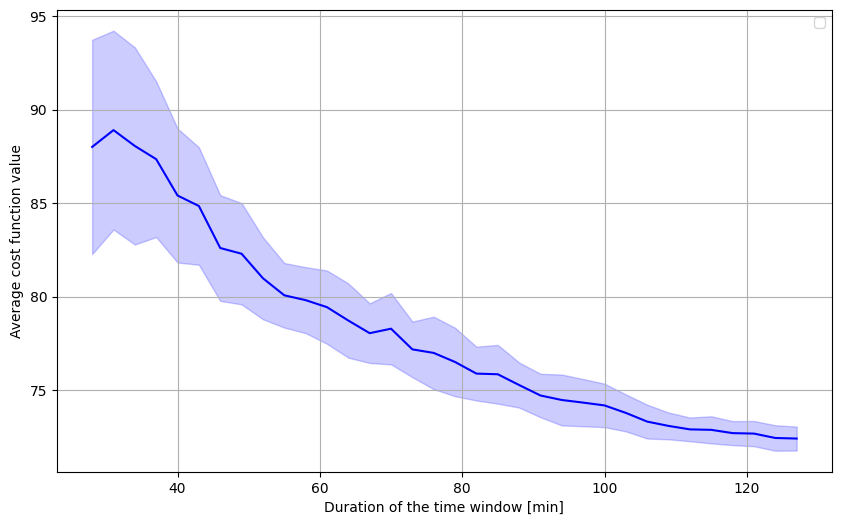

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
from scipy import stats


averages = []
conf_intervals = []

for sublist in cost:
    numeric_values = [x for x in sublist if isinstance(x, (int, float))]
    if numeric_values:
        avg = np.mean(numeric_values)
        std_dev = np.std(numeric_values, ddof=1)
        n = len(numeric_values)
        df = n - 1

        t_value = stats.t.ppf(1 - 0.025, df)

        ci = (avg - t_value * std_dev / np.sqrt(n),
              avg + t_value * std_dev / np.sqrt(n))
    else:
        avg = 0
        ci = (0, 0)
    averages.append(avg)
    conf_intervals.append(ci)

lower_bounds = [ci[0] for ci in conf_intervals]
upper_bounds = [ci[1] for ci in conf_intervals]

plt.figure(figsize=(10, 6))
plt.plot(time_window_time_list[7:], averages[7:], linestyle='-', color='blue')
plt.fill_between(time_window_time_list[7:], lower_bounds[7:], upper_bounds[7:], color='blue', alpha=0.2)
plt.xlabel('Duration of the time window [min]')
plt.ylabel('Average cost function value')
plt.grid(True)
plt.legend()
plt.show()

In [ ]:
counts = [lst.count("INFEISABLE") for lst in cost]
counts.sort(reverse=True)
for i, count in enumerate(counts):
    print(f"Lista {7 + i*3}: {count} razy INFEISABLE")

Lista 7: 20 razy INFEISABLE
Lista 10: 19 razy INFEISABLE
Lista 13: 19 razy INFEISABLE
Lista 16: 19 razy INFEISABLE
Lista 19: 18 razy INFEISABLE
Lista 22: 15 razy INFEISABLE
Lista 25: 13 razy INFEISABLE
Lista 28: 8 razy INFEISABLE
Lista 31: 5 razy INFEISABLE
Lista 34: 5 razy INFEISABLE
Lista 37: 3 razy INFEISABLE
Lista 40: 3 razy INFEISABLE
Lista 43: 2 razy INFEISABLE
Lista 46: 1 razy INFEISABLE
Lista 49: 0 razy INFEISABLE
Lista 52: 0 razy INFEISABLE
Lista 55: 0 razy INFEISABLE
Lista 58: 0 razy INFEISABLE
Lista 61: 0 razy INFEISABLE
Lista 64: 0 razy INFEISABLE
Lista 67: 0 razy INFEISABLE
Lista 70: 0 razy INFEISABLE
Lista 73: 0 razy INFEISABLE
Lista 76: 0 razy INFEISABLE
Lista 79: 0 razy INFEISABLE
Lista 82: 0 razy INFEISABLE
Lista 85: 0 razy INFEISABLE
Lista 88: 0 razy INFEISABLE
Lista 91: 0 razy INFEISABLE
Lista 94: 0 razy INFEISABLE
Lista 97: 0 razy INFEISABLE
Lista 100: 0 razy INFEISABLE
Lista 103: 0 razy INFEISABLE
Lista 106: 0 razy INFEISABLE
Lista 109: 0 razy INFEISABLE
Lista 112: